# X-ray Speckle Visibility Spectroscopy
The analysis module "skxray/core/speckle" https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/speckle.py

In [2]:
import skxray.core.speckle as xsvs
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as core

import xray_vision.mpl_plotting as mpl_plot
import xray_vision.mpl_plotting.speckle as speckle_plot

import numpy as np
import os, sys
import zipfile

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid

### Easily switch between interactive and static matplotlib plots¶

In [3]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

### This data provided by Dr. Andrei Fluerasu
L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini, C. Carona and A. Fluerasu ,
"Photon statistics and speckle visibility spectroscopy with partially coherent x-rays"
J. Synchrotron Rad., vol 21, p 1288-1295, 2014.

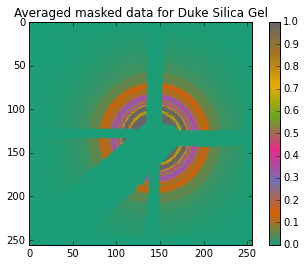

In [4]:
folder = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/Duke_data/"
#folder = os.path.join(*__file__.split(os.sep)[:-1])

#  Get the data and the mask 
try:
    duke_data = np.load(os.path.join(folder, "duke_data", "duke_data.npy"))
    N_mask = np.load(os.path.join(folder, "duke_data", "N_mask.npy"))
except IOError:
    zipfile.ZipFile(os.path.join(folder, "duke_data.zip")).extractall()
    duke_data = np.load(os.path.join(folder, "duke_data", "duke_data.npy"))
    N_mask = np.load(os.path.join(folder, "duke_data", "N_mask.npy"))

#  get the average image
avg_img = np.average(duke_data, axis=0)

# plot the average image data after masking
plt.figure()
plt.imshow(N_mask*avg_img, vmax=1e0, cmap='Dark2')
plt.title("Averaged masked data for Duke Silica Gel ")
plt.colorbar()
plt.show()

### Create the Rings Mask¶
Use the skxray.core.roi module to create Ring ROIs (ROI Mask).¶
(https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/roi.py)

In [37]:
inner_radius = 26  # radius of the first ring
width = 1        # width of each ring
spacing = 0      # no spacing between rings
num_rings = 4    # number of rings
center = (133, 143)   # center of the spckle pattern

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 26.,  27.],
       [ 27.,  28.],
       [ 28.,  29.],
       [ 29.,  30.]])

###  Convert the edge values of the rings to q ( reciprocal space)

In [38]:
dpix = 0.055  # The physical size of the pixels

lambda_ = 1.5498  # wavelength of the X-rays
Ldet = 2200.   #   # detector to sample distance

two_theta = core.radius_to_twotheta(Ldet, edges*dpix)
q_val = core.twotheta_to_q(two_theta, lambda_)

q_val

array([[ 0.00263522,  0.00273658],
       [ 0.00273658,  0.00283793],
       [ 0.00283793,  0.00293929],
       [ 0.00293929,  0.00304064]])

In [39]:
q_ring = np.mean(q_val, axis=1)
q_ring

array([ 0.0026859 ,  0.00278726,  0.00288861,  0.00298997])

### Create a labeled array using roi.rings

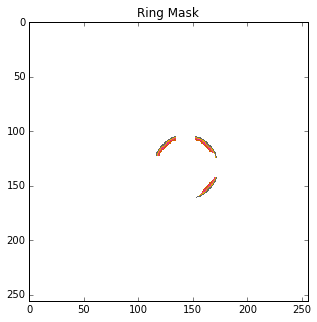

In [48]:
rings = roi.rings(edges, center, avg_img.shape)

#images_sets = np.asarray(list(N_mask*duke_data), )
images_sets = (N_mask*duke_data[0:5000],)

ring_mask = rings*N_mask

# plot the figure
fig, axes = plt.subplots(figsize=(5, 5))
axes.set_title("Ring Mask")
im = mpl_plot.show_label_array(axes, ring_mask, cmap="Dark2")
plt.show()

### Find the brightest pixel in any ROI in any image in the image set.
Using roi_max_counts function from skxray.core.roi module

In [49]:
max_cts = roi.roi_max_counts(images_sets, ring_mask)
max_cts

24

### Everything looks good, next X-ray speckle visibilty spectroscopy
This function will provide the probability density of detecting photons
for different integration time.
Using skxray.core.speckle module

In [50]:
spe_cts_all, std_dev = xsvs.xsvs(images_sets, ring_mask, timebin_num=2,
                             number_of_img=50, max_cts=max_cts)

### Find the integration times
using skxray.core.utils.geometric_series

In [51]:
time_steps = core.geometric_series(2, 50)
time_steps

[1, 2, 4, 8, 16, 32]

## Get the mean intensity of each ring

In [52]:
mean_int_sets, index_list = roi.mean_intensity(N_mask*duke_data[0:5000], ring_mask)

In [53]:
mean_int_sets.shape

(5000, 4)

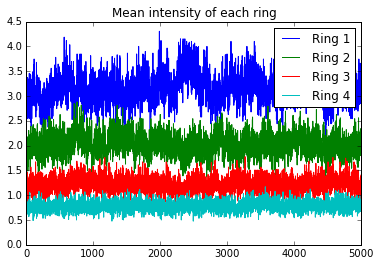

In [56]:
plt.figure()
plt.title("Mean intensity of each ring")
for i in range(num_rings):
    plt.plot(mean_int_sets[:,i], label="Ring "+str(i+1))
plt.legend()    
plt.show()

In [57]:
mean_int_ring = np.mean(mean_int_sets, axis=0)
mean_int_ring

array([ 3.17503051,  2.03199322,  1.22062687,  0.78536136])

###  Get the normalized bin edges and bin centers for each integration time.

using skxray.core.speckle.normalize_bin_edges

In [58]:
num_times = 6
num_rois=num_rings
norm_bin_edges, norm_bin_centers = xsvs.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

### 1st q ring 0.0026859 (1/Angstroms)

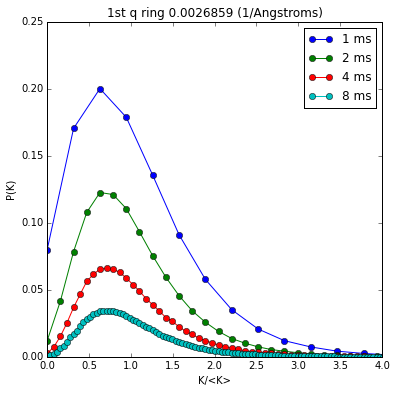

In [59]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], spe_cts_all[i, 0], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("1st q ring 0.0026859 (1/Angstroms)")
plt.show()

### 2nd q ring 0.00278726 (1/Angstroms)¶

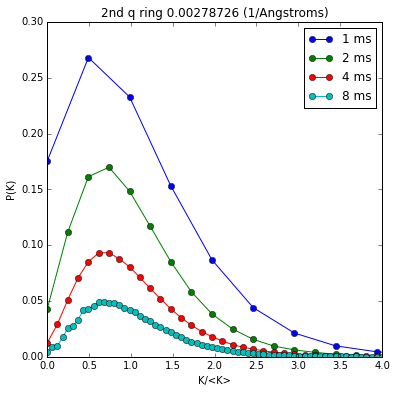

In [60]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 1][:-1], spe_cts_all[i, 1], '-o', label=str(time_steps[i])+" ms")
    axes.legend()
    axes.set_xlim(0, 4)
plt.title("2nd q ring 0.00278726 (1/Angstroms)")
plt.show()

### 3rd q ring 0.00288861 (1/ Angstroms)

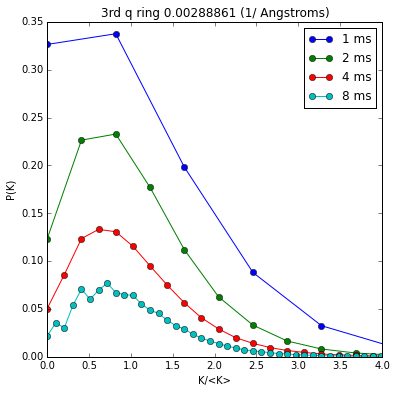

In [61]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 2][:-1], spe_cts_all[i, 2], '-o', label=str(time_steps[i])+" ms" )
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("3rd q ring 0.00288861 (1/ Angstroms)")
plt.show()

### 4th q ring 0.0298997 (1/ Angstroms)

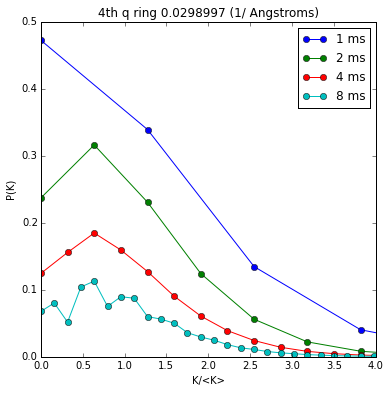

In [36]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 3][:-1], spe_cts_all[i, 3], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("4th q ring 0.0298997 (1/ Angstroms)")
plt.show()

In [22]:
import skxray
print(skxray.__version__)

0.0.4+110.gfdd0b8a.dirty
